In [29]:
import pandas as pd
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import seaborn as sns
import math
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from collections import defaultdict
from sklearn.metrics import mean_absolute_error, mean_squared_error
from abc import ABC, abstractmethod
import re
from transformers import AutoModel, AutoTokenizer
import pickle
import time
import itertools
from scipy.spatial import distance

from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
import seaborn as sns
import string
from sklearn.metrics.pairwise import cosine_similarity
from final_hyperparams import BinnedSeqDataset, LSTMForecasterMF

In [2]:
import os
os.environ['LD_LIBRARY_PATH'] = '/path/to/conda/env/lib:' + os.environ.get('LD_LIBRARY_PATH', '')

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


In [4]:
import torch
print(torch.version.cuda)

11.6


In [5]:
import re
from scipy.stats import chi2_contingency,pointbiserialr,pearsonr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from nltk.corpus import stopwords

In [38]:
def check_empty_input_seq(count_mat):
    """
    count_mat -> 9,7
    count_mat_input -> 8,7
    
    so if entire sum of mat <=56 (since 0->1)
    then sequence is empty from engagements
    """
    assert count_mat.shape[0] == 9
    
    if np.sum(count_mat[:-1,:])<=56:
        return True
    else:
        return False
    
def filter_observations(obs_list):
    """
    remove observations where there in no engagement activity across the entire input sequence
    """
    filtered_obs = []
    for obs in tqdm.tqdm(obs_list):
        if not check_empty_input_seq(obs["original_counts"]):
            filtered_obs.append(obs)
    
    print(f"Filtered Size : {len(filtered_obs)}")
    print(f"Removed {len(obs_list) - len(filtered_obs)} empty observations")
    return filtered_obs

def get_test_by_user_date(test_set):
    """
    """
    res = defaultdict(lambda : defaultdict())
    for tinst in tqdm.tqdm(test_set):
        res[list(set(tinst["username"]))[0]][tinst["date_ranges"][-1][0]] = tinst
    
    for user in res.keys():
        res[user] = [res[user][key] for key in sorted(res[user].keys(), reverse=False)]
    return res


def get_all_user_instances():
    """
    """
    all_instances = defaultdict(list)
    
    for i in [1,2,3,4]:
        
        test = pickle.load(open(f"pickled_data/r{i}_test.pkl","rb"))
        test = filter_observations(test)
        
        user_instances = get_test_by_user_date(test)
        
        for user in user_instances:
            all_instances[user]+=user_instances[user]
    
    return all_instances

def load_model(model_file, primary_device='cuda:2', device_ids=[2, 0, 1]):
    """
    Load a DataParallel model and change its device assignment.

    Parameters:
        model_file (str): Path to the saved model file.
        primary_device (str): The primary device to use for DataParallel (default: 'cuda:2').
        device_ids (list): List of device IDs for DataParallel (default: [2, 0, 1]).

    Returns:
        nn.Module: The loaded model with updated DataParallel device assignment.
    """
    # Load the saved model
    model = torch.load(model_file, map_location=primary_device)

    # Check if the loaded model is a DataParallel object
    if isinstance(model, nn.DataParallel):
        # Update the device_ids and re-wrap the model with DataParallel
        model = nn.DataParallel(model.module, device_ids=device_ids).to(primary_device)
    else:
        # If the model is not a DataParallel object, wrap it with DataParallel
        model = nn.DataParallel(model, device_ids=device_ids).to(primary_device)

    return model


def get_hidden_user_reps(all_user_instances,sf=1):
    """
    """
    models = None
    
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    
    if sf == 1:
        
        model1 = torch.load("final_models/count_model_data_1.pth")
        model1.to(device)
        model1.eval()

        model2 = torch.load("final_models/count_model_data_2.pth")
        model2.to(device)
        model2.eval()

        model3 = torch.load("final_models/count_model_data_3.pth")
        model3.to(device)
        model3.eval()

        model4 = torch.load("final_models/count_model_data_4.pth")
        model4.to(device)
        model4.eval()

        models = [model1,model2,model3,model4]
    
    if sf == 2:
        
        model1 = torch.load("final_models/text_model_data_1.pth")
        model1.to(device)
        model1.eval()

        model2 = torch.load("final_models/text_model_data_2.pth")
        model2.to(device)
        model2.eval()

        model3 = torch.load("final_models/text_model_data_3.pth")
        model3.to(device)
        model3.eval()

        model4 = torch.load("final_models/text_model_data_4.pth")
        model4.to(device)
        model4.eval()

        models = [model1,model2,model3,model4]
    
    if sf == 3:
        
        model1 = load_model(model_file="final_models/all_model_data_1.pth", 
                   primary_device='cuda:2', 
                   device_ids=[2, 3])
        
        model1.eval()
        model2 = load_model(model_file="final_models/all_model_data_2.pth", 
                   primary_device='cuda:2', 
                   device_ids=[2, 3])
        
        model2.eval()
        model3 = load_model(model_file="final_models/all_model_data_3.pth", 
                   primary_device='cuda:2', 
                   device_ids=[2, 3])
        
        model3.eval()
        model4 = load_model(model_file="final_models/all_model_data_4.pth", 
                   primary_device='cuda:2', 
                   device_ids=[2, 3])
        
        model4.eval()
        models = [model1,model2,model3,model4]
        
#         model1 = torch.load("final_models/all_model_data_1.pth")
#         model1.to(device)
#         # model1.eval()

#         model2 = torch.load("final_models/all_model_data_2.pth")
#         model2.to(device)
#         # model2.eval()

#         model3 = torch.load("final_models/all_model_data_3.pth")
#         model3.to(device)
#         # model3.eval()

#         model4 = torch.load("final_models/all_model_data_4.pth")
#         model4.to(device)
#         # model4.eval()
        
#         device_ids = [2,3]
#         model1 = nn.DataParallel(model1, device_ids=device_ids)
#         model2 = nn.DataParallel(model2, device_ids=device_ids)
#         model3 = nn.DataParallel(model3, device_ids=device_ids)
#         model4 = nn.DataParallel(model4, device_ids=device_ids)
#         model1.to(device)
#         model1.eval()
#         model2.eval()
#         model3.eval()
#         model4.eval()
            
        # models = [model1,model2,model3,model4]
    
    
    user_hiddenstates = defaultdict(list)
    user_engagementcounts = defaultdict(list)
    user_label_counts = defaultdict(list)
    user_pred_counts = defaultdict(list)
    user_means = defaultdict(list)
    user_stds = defaultdict(list)
    
    
    with torch.set_grad_enabled(False):
        
        for user in tqdm.tqdm(all_user_instances):
            
            for idx,mc in enumerate(models):
               
                obs = all_user_instances[user][idx*4:(idx*4)+4]
                
                tempd = BinnedSeqDataset(obs)
                temploader =  torch.utils.data.DataLoader(tempd,shuffle=False,batch_size=4)

                for batch in temploader:
                    batch["label_zscored"] = batch["label_zscored"].to(device)
                    batch["eng_counts"] = batch["eng_counts"].to(device)
                    batch["input_time_feat"] = batch["input_time_feat"].to(device)
                    batch["output_time_feat"] = batch["output_time_feat"].to(device)
                    batch["ns_feat"] =  batch["ns_feat"].to(device)
                    batch["mentions_feat"] =  batch["mentions_feat"].to(device)
                    batch["hashtag_feat"] =  batch["hashtag_feat"].to(device)
                    batch["text_feat"] =  batch["text_feat"].to(device)
                   

                    if sf == 1:
                        hidden_state , y_pred = mc(batch["eng_counts"])

                    if sf == 2:
                        hidden_state, y_pred = mc(batch["text_feat"])

                    if sf == 3:
                        hidden_state, y_pred = mc(batch["eng_counts"],
                                                      batch["input_time_feat"],
                                                      batch["output_time_feat"],
                                                      batch["ns_feat"],
                                                      batch["mentions_feat"],
                                                      batch["hashtag_feat"],
                                                      batch["text_feat"])
                    
                    
                    user_hiddenstates[user].append(hidden_state.detach().cpu().numpy().reshape(1,-1))
                    
                    # original counts are the engagement counts of the input timesteps
                    user_engagementcounts[user].append(batch["original_counts"].reshape(-1,7).numpy())
                    
                    # label counts are the true label counts of the forecasting timestep (8th timestep)
                    user_label_counts[user].append(batch["label_original"].numpy())
                    
                    user_pred_counts[user].append(y_pred.detach().cpu().numpy())
                    
                    user_means[user].append( batch["means"].numpy())
                    user_stds[user].append( batch["stddevs"].numpy())
            
            
            
            user_hiddenstates[user] = np.concatenate(user_hiddenstates[user],axis=1)
            user_engagementcounts[user] = np.concatenate(user_engagementcounts[user],axis=0)
            user_label_counts[user] = np.concatenate(user_label_counts[user],axis=0)
            
            user_pred_counts[user] = np.concatenate(user_pred_counts[user],axis=0)
            user_means[user] = np.concatenate(user_means[user],axis=0)
            user_stds[user] = np.concatenate(user_stds[user],axis=0)
            
            user_pred_counts[user] =  (user_pred_counts[user] * user_stds[user]) + user_means[user]
            
    
    models = None
    del models
    
    model1 = None
    del model1

    model2 = None
    del model2

    model3 = None
    del model3

    model4 = None
    del model4
    
    torch.cuda.empty_cache()
    
    return user_hiddenstates, user_engagementcounts, user_label_counts, user_pred_counts


def get_max_shape(user_hidden_states):
    """
    # some users don't have test instances in all splits due to empty engagements
    # So we only consider users who are present in all test sets
    """
    shapes = []
    for idx,user in enumerate(user_hidden_states):
        shapes.append(user_hidden_states[user].shape[1])

    shape_counter = Counter(shapes)
    return shape_counter.most_common(1)[0][0]
    

def cluster_users(user_hidden_states,k=25):
    """
    """
    vecs = []
    users = []
    
    most_frequent_shape =  get_max_shape(user_hidden_states)
    
    print(f"Most Frequent Shape : {most_frequent_shape}\n")
    
    for idx,user in tqdm.tqdm(enumerate(sorted(user_hidden_states.keys()))):
        if user_hidden_states[user].shape[1] == most_frequent_shape:
            vecs.append(user_hidden_states[user])
            users.append(user)
    # users who have some engagement across time periods used in test sets
    print(f"No of Users Considered : {len(vecs)}\n")
    
    vecs = np.concatenate(vecs,axis=0)
    
    start = time.time()
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    preds = kmeans.fit_predict(vecs)
    stop = time.time()
    print(f"Elapsed Time for Clustering : {round((stop-start)/60,3)} mins\n")
    
    cluster_2_user_map = defaultdict(list)
    
    for idx,p in tqdm.tqdm(enumerate(preds)):
        cluster_2_user_map[p].append(users[idx])
    
    cluster_size_map = {}
    for clust in sorted(cluster_2_user_map.keys()):
        print(f"Cluster : {clust : <4} | Num users : {len(cluster_2_user_map[clust])}")
        cluster_size_map[clust] = len(cluster_2_user_map[clust])
    
    print(f"\nAverage Number of Users per Cluster : {np.mean([len(cluster_2_user_map[clust]) for clust in sorted(cluster_2_user_map.keys())])}")
    print(f"Max Number of Users in a Cluster : {np.max([len(cluster_2_user_map[clust]) for clust in sorted(cluster_2_user_map.keys())])}")
    print(f"Min Number of Users in a Cluster : {np.min([len(cluster_2_user_map[clust]) for clust in sorted(cluster_2_user_map.keys())])}")
    
    return cluster_2_user_map,cluster_size_map

    
def get_centroid_user_ranking_based(cluster_2_user_map, engagement_counts):
    """
    """
    centroid_users = defaultdict(lambda : defaultdict())
    for idx,cluster in enumerate(sorted(cluster_2_user_map.keys())):
        users = cluster_2_user_map[cluster]
        eng_counts = []
        for user in users: 
            eng_counts.append(engagement_counts[user].reshape(1,-1,7))

        eng_counts=np.concatenate(eng_counts,axis=0)

        eng_counts_reshaped = eng_counts.reshape(eng_counts.shape[0],-1)
        
        cosine_mat = cosine_similarity(eng_counts_reshaped)
        np.fill_diagonal(cosine_mat,-np.inf)
        most_similar_user_indices = np.argmax(cosine_mat, axis=1)
    
        most_common_user_index = Counter(most_similar_user_indices.tolist()).most_common(1)[0][0]

        most_common_user = users[most_common_user_index]
        most_common_engagement_pattern = eng_counts[most_common_user_index]
        
        centroid_users[cluster]["user"] = most_common_user
        centroid_users[cluster]["engagement_counts"] = most_common_engagement_pattern
        
    return centroid_users
        

def get_centroid_user_mean_sim(cluster_2_user_map, engagement_counts):
    """
    """
    centroid_users = defaultdict(lambda : defaultdict())
    for idx,cluster in enumerate(sorted(cluster_2_user_map.keys())):
        users = cluster_2_user_map[cluster]
        eng_counts = []
        for user in users: 
            eng_counts.append(engagement_counts[user].reshape(1,-1,7))

        eng_counts=np.concatenate(eng_counts,axis=0)

        eng_counts_reshaped = eng_counts.reshape(eng_counts.shape[0],-1)
        
        cosine_mat = cosine_similarity(eng_counts_reshaped)
    
        diagonal_indices = np.diag_indices(cosine_mat.shape[0])

        masked_cosine_mat = np.ma.masked_array(cosine_mat, mask=False)
        masked_cosine_mat.mask[diagonal_indices] = True

        mean_cosine_sim_users = np.mean(masked_cosine_mat,axis=1)
        sorted_user_indices = np.argsort(-mean_cosine_sim_users)
        
        most_similar_user = users[sorted_user_indices[0]]
        most_similar_user_eng = eng_counts[sorted_user_indices[0]]
        
        centroid_users[cluster]["user"] = most_similar_user
        centroid_users[cluster]["engagement_counts"] = most_similar_user_eng
    
    return centroid_users

def get_mean_user(cluster_user_map, engagement_counts):
    """
    """
    
    mean_users = defaultdict(lambda : defaultdict())
    for idx,cluster in enumerate(sorted(cluster_user_map.keys())):
        users = cluster_user_map[cluster]
        mean_counts = []
        for user in users:
            mean_counts.append(engagement_counts[user].reshape(1,-1,7))
            
        mean_counts=np.concatenate(mean_counts,axis=0)
        mean_counts = np.mean(mean_counts,axis=0)
        
        mean_users[cluster]["user"] = cluster
        mean_users[cluster]["engagement_counts"] = mean_counts
    
    return mean_users

def get_engagement_count_centers(cluster_user_map,user_engagement_counts,centroid=False):
    """
    """
    
    eng_counts_per_cluster = None
    
    if centroid:
        eng_counts_per_cluster = get_centroid_user_mean_sim(cluster_user_map, user_engagement_counts)
    
    else:
        eng_counts_per_cluster = get_mean_user(cluster_user_map, user_engagement_counts)
    
    
    return eng_counts_per_cluster

def get_top_words(top_cluster_terms,k=3):
    """
    """
    words = [t for t in top_cluster_terms if "@" not in t[0]]
    return [w[0] for w in words][:k]

In [7]:
def remove_urls(text):
    # Regular expression pattern to match URLs
    url_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"

    # Remove URLs from the text using regex substitution
    cleaned_text = re.sub(url_pattern, "", text)
    
    return cleaned_text

def get_chisquare_vals_and_correlation(X,labels,vectorizer):
    """
    """
    
    chi2_scorer = SelectKBest(score_func=chi2, k="all")
    chi2_scorer.fit(X,labels)

    # Get sorted important terms
    terms_chi2 = zip(vectorizer.get_feature_names(), chi2_scorer.scores_)
    terms_chi2 = sorted(terms_chi2, key=lambda x: x[1], reverse=True)
    
    correlation_coeffs, _ = zip(*[pearsonr(np.array(X[:,i]).flatten(), np.array(labels)) for i in range(X.shape[1])])
    
    terms_correlation = zip(vectorizer.get_feature_names(), np.array(correlation_coeffs))
    term_corr_map = {key: value for key, value in terms_correlation}
    
    filtered_terms = []

    for idx,it in enumerate(terms_chi2):
        if  term_corr_map[it[0]]>0:
            filtered_terms.append((it[0],it[1],term_corr_map[it[0]]))
    
    # print(f"Terms before Filtering for correlation : {len(terms_chi2)}")
    # print(f"Terms after Filtering for correlation : {len(filtered_terms)}")
    
    return filtered_terms

def get_user_docs(cluster_2_user_map):
    """
    """
    user_docs = defaultdict(list)
    for c in tqdm.tqdm(sorted(cluster_2_user_map.keys())):
        users = cluster_2_user_map[c]
        for user in users:
            df_user = pd.read_pickle(f"../../../Data/new_matched_timelines/{user}")
            df_user["created_at"] = pd.to_datetime(df_user["created_at"])
            df_user_fh_text = df_user.loc[df_user["created_at"]>="2018-01-01","text"].tolist()
            user_text = " ".join(df_user_fh_text)
            user_docs[user] = user_text
            
            
    return user_docs

def get_user_docs_by_time(cluster_2_user_map):
    """
    """
    date_ranges = ["2018-01-01","2019-01-01","2020-01-01","2021-01-01","2022-01-01"]
    user_docs = defaultdict(lambda: defaultdict(list))
    for c in tqdm.tqdm(sorted(cluster_2_user_map.keys())):
        users = cluster_2_user_map[c]
        for user in users:
            df_user = pd.read_pickle(f"../../../Data/new_matched_timelines/{user}")
            df_user["created_at"] = pd.to_datetime(df_user["created_at"])
            for didx in range(0,len(date_ranges)-1):
                df_text_date = df_user.loc[(df_user["created_at"]>=date_ranges[didx]) & (df_user["created_at"]<date_ranges[didx+1]),"text"].tolist()
                user_text_date = " ".join(df_text_date)
                user_docs[user][date_ranges[didx].split("-")[0]] = user_text_date
            
    return user_docs

def find_top_terms(cluster_2_user_map,user_docs,date_range=None,min_users=10,max_users=0.95,max_terms=10000,binary=False):
    """
    """
        
    cluster_imp_terms = defaultdict()
    
    if not date_range:
        users,docs = zip(*list(user_docs.items()))
    
    if date_range:
        users = []
        docs = []
        for u in user_docs.keys():
            users.append(u)
            docs.append(user_docs[u][date_range.split("-")[0]])
        
        assert len(users) > 0
        assert len(docs) > 0
    
    stopwords_list = stopwords.words('english')
    
    def tokenize(tweet):
        """
        """
        nonlocal stopwords_list
        
        tweet = remove_urls(tweet)
        pattern = r"[^\w\s#@-]" # remove all punctuations except #,@ and -
        tweet = re.sub(pattern, "", tweet) 
        tweet = re.sub('\s+', ' ', tweet).strip() # remove all extra spaces

        terms = [t.lower() for t in tweet.split(" ") if len(t)>2 and t.lower().strip() not in stopwords_list]
        if len(terms)<=0:
            return [""]

        return terms
    
    vectorizer = CountVectorizer(tokenizer=tokenize,
                                 min_df=min_users,
                                 max_df=max_users,
                                 max_features=max_terms,
                                 binary=binary,
                                 lowercase=True)
    start = time.time()
   
    X = vectorizer.fit_transform(docs)
    
    stop = time.time()
    print(f"Fitting vectorizer : {round((stop-start)/60,2)} mins")
    
    X = X.todense()
    
    for c in tqdm.tqdm(sorted(cluster_2_user_map.keys())):
        # print(f"\nCluster : {c}")
        cluster_users = cluster_2_user_map[c]
        # print(f"No of Users : {len(cluster_users)}")
        
        labels = []
        
        for user in users:
            if user in cluster_users:
                labels.append(1)
            else:
                labels.append(0)
        
        important_terms = get_chisquare_vals_and_correlation(X,labels,vectorizer)
        cluster_imp_terms[c] = important_terms
        
    return cluster_imp_terms

def find_top_terms_by_time(cluster_2_user_map,user_docs,min_users=10,max_users=0.95,max_terms=10000,binary=False):
    """
    """
    date_ranges = ["2018-01-01","2019-01-01","2020-01-01","2021-01-01"]
    
    date_cluster_terms = {}
    
    for d in date_ranges:
        # print(f"\nDate : {d}")
        date_top_terms = find_top_terms(cluster_2_user_map,
                                       user_docs,
                                       date_range=d,
                                       min_users=min_users,
                                       max_users=max_users,
                                       max_terms=max_terms,
                                       binary=binary)
        
        date_cluster_terms[d.split("-")[0]] = date_top_terms
    
    return date_cluster_terms
        
    

In [53]:
def discretize_matrix_equal_frequency(matrix, num_bins):
    # Flatten the matrix into a 1D array
    flattened_data = matrix.flatten()

    # Perform equal frequency binning using pandas.qcut()
    _, bin_edges = pd.qcut(flattened_data, num_bins-1, retbins=True, duplicates='drop')

    # Calculate the bin edges to ensure outliers are in the last bin
    equal_freq_edges = list(bin_edges) + [np.inf]

    # Discretize the matrix into equal frequency bins
    discretized_matrix = np.digitize(flattened_data, equal_freq_edges, right=True)

    # Reshape the discretized matrix to match the original shape
    discretized_matrix = discretized_matrix.reshape(matrix.shape)

    return discretized_matrix

def bin_intervals(matrix,num_bins):
    """
    """
    flattened_data = matrix.flatten()

    # Perform equal frequency binning using pandas.qcut()
    _, bin_edges = pd.qcut(flattened_data, num_bins-1, retbins=True, duplicates='drop')

    # Calculate the bin edges to ensure outliers are in the last bin
    equal_freq_edges = list(bin_edges) + [np.inf]
    
    return equal_freq_edges

def convert_2_bins(matrix,bin_edges):
    """
    """
    flattened_data = matrix.flatten()
    
    discretized_matrix = np.digitize(flattened_data, bin_edges, right=True)

    # Reshape the discretized matrix to match the original shape
    discretized_matrix = discretized_matrix.reshape(matrix.shape)

    return discretized_matrix

def get_news_sources_user_level(cluster_2_user_map):
    """
    """
    news_sources_per_user = defaultdict(list)
    for c in tqdm.tqdm(sorted(cluster_2_user_map.keys())):
        users = cluster_2_user_map[c]
        for user in users:
            df_user = pd.read_pickle(f"../../../Data/new_matched_timelines/{user}")
            df_matched_ps = df_user.loc[df_user["matched_partisans"].str.len()>0]
            news_sources = df_matched_ps["matched_sources"].tolist()
            news_sources_per_user[user] = news_sources
    
    return news_sources_per_user

def top_news_sources_per_cluster(cluster_2_user_map,user_2_ns_map,topk=10):
    """
    """
    cluster_2_ns_map = defaultdict(list)
    for c in tqdm.tqdm(sorted(cluster_2_user_map.keys())):
        users = cluster_2_user_map[c]
        ns_count = Counter()
        total = 0
        for user in users:
            ns = user_2_ns_map[user]
            for n in ns:
                total += len(n)
                ns_count.update(n)
        cluster_2_ns_map[c] = [(nt[0],nt[1],round(nt[1]/total,2)) for nt in ns_count.most_common(topk)]
    
    return cluster_2_ns_map
    
    

def plot_clusters(rows,
                  columns,
                  engagement_counts_main,
                  figsize=(18,10),
                  save_path="",
                  cluster_important_terms=None,
                  cluster_important_terms_date=None,
                  num_bins=10,
                  color="#9818D6",
                  cluster_sizes=None):
    """
    """
    cmap = sns.light_palette(f"{color}", n_colors=num_bins)
        
    avg_eng_counts_per_cluster = []
    avg_eng_stances_per_cluster = []
    
    
    for idx,cluster in enumerate(sorted(engagement_counts_main.keys())):
        eng_counts = engagement_counts_main[idx]["engagement_counts"]
        avg_eng_counts_per_cluster.append(np.mean(eng_counts))
        
        stances_temp = []
        for jdx,i in enumerate([-3,-2,-1,0,1,2,3]):
            stances_temp+= [i]*int(eng_counts[:,jdx].sum())
        
        avg_eng_stances_per_cluster.append(np.mean(stances_temp))
        
    
    sorted_clusters_by_engagement_counts = np.argsort(avg_eng_counts_per_cluster)
    sorted_clusters_by_partisan_stance = np.argsort(avg_eng_stances_per_cluster)

    
    print(f"\nClusters Sorted by Avg Partisan Stance :")
    fig,ax = plt.subplots(rows,columns,figsize=figsize,sharex=True)
    
    axes = ax.ravel()
    
    remapped_cluster_labels = {}
    
    all_counts = []
    for idx,cluster in enumerate(sorted_clusters_by_partisan_stance):
        eng_counts = engagement_counts_main[cluster]["engagement_counts"]
        all_counts.append(eng_counts.flatten())
    
    all_counts = np.array(all_counts)
    
    bin_edges = bin_intervals(all_counts,num_bins)
        
    
    for idx,cluster in enumerate(sorted_clusters_by_partisan_stance):
        
        
        remapped_cluster_labels[cluster] = idx
        
        eng_counts = engagement_counts_main[cluster]["engagement_counts"]

        xlabels = [f"2018-{i}" for i in range(1,5)]+ [f"2019-{i}" for i in range(1,5)] + [f"2020-{i}" for i in range(1,5)] + [f"2021-{i}" for i in range(1,4)]
        
        cbar=False
        yticklabels = []
            
        eng_counts = convert_2_bins(eng_counts,bin_edges)

        min_ = 0
        max_ = num_bins-1
                
        if idx%4==0:
            yticklabels = [f"{i}" for i in range(-3,4)]
            
        
        hm = sns.heatmap(eng_counts.transpose(),
                    ax=axes[idx],
                    vmin=min_,
                    vmax=max_,
                    cmap=cmap,
                    linewidth=0.0,
                    linecolor="white",
                    xticklabels=xlabels,
                    yticklabels=yticklabels,
                    cbar=cbar)
        
        if idx%4==0:
            hm.set_yticklabels(hm.get_yticklabels(), rotation = 0)
        if idx%4 != 0:
            hm.set_yticklabels([])
        
        for _, spine in hm.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(1)
        
        
        axes[idx].tick_params(axis='x', which='both', length=0)
        axes[idx].tick_params(axis='both', which='major', labelsize=16)
        top_words = get_top_words(cluster_important_terms[cluster],k=3)
        
        top_words_2018 = get_top_words(cluster_important_terms_date["2018"][cluster],k=3)
        top_words_2019 = get_top_words(cluster_important_terms_date["2019"][cluster],k=3)
        top_words_2020 = get_top_words(cluster_important_terms_date["2020"][cluster],k=3)
        top_words_2021 = get_top_words(cluster_important_terms_date["2021"][cluster],k=3)
        
        avg_stance_ = avg_eng_stances_per_cluster[cluster]
          
        title_text = "#"+r"$\mathbf{%s}$"%str(idx+1)+f"  {round((int(cluster_sizes[cluster])/4874)*100,1)}%  {round(float(avg_stance_),2)}\n"
        
        max_length = max([len(','.join(top_words_2018)),len(','.join(top_words_2019)),len(','.join(top_words_2020)),len(','.join(top_words_2021))])+4
      
        text_2018 = "$\mathbf{2018}$:"+f"{','.join(top_words_2018)}\n"
        text_2019 = "$\mathbf{2019}$:"+f"{','.join(top_words_2019)}\n"
        text_2020 = "$\mathbf{2020}$:"+f"{','.join(top_words_2020)}\n"
        text_2021 = "$\mathbf{2021}$:"+f"{','.join(top_words_2021)}"
        
        text_title = "{:<{}}".format(title_text,max_length)
        text_2018 = "{:<{}}".format(text_2018,max_length)
        text_2019 = "{:<{}}".format(text_2019,max_length)
        text_2020 = "{:<{}}".format(text_2020,max_length)
        text_2021 = "{:<{}}".format(text_2021,max_length)
       
        title_text = title_text + text_2018 + text_2019 + text_2020 + text_2021
        
        title = axes[idx].set_title(title_text,fontsize=14)
        
        title.set_bbox(dict(facecolor='#DDE6ED', edgecolor='black', boxstyle='round,pad=0.29'))
    
    
    new_labels = []
    for bidx in range(len(bin_edges)-2):
        lab_ = f'{round(bin_edges[bidx])}' + '$\leq x <$' + f'{round(bin_edges[bidx+1])}'
        new_labels.append(lab_)
    
    new_labels.append(f'{round(bin_edges[-2])}'+ '$\leq x$')
    
    cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
    
    cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='horizontal')
   
    cbar.set_ticks([0.45, 1.2, 2,2.8,3.6])
    cbar.set_ticklabels(new_labels)
    cbar.ax.tick_params(labelsize=18)
    
    # if you want bold colorbar labels
    # for label in cbar.ax.xaxis.get_ticklabels():
    #     label.set_fontsize(16)
    #     label.set_fontweight('bold')
    
    fig.tight_layout(rect=[0, 0.1, 1, 1])
    fig.savefig(save_path,dpi=300)
    plt.show()
    
    return remapped_cluster_labels

In [9]:
all_user_instances = get_all_user_instances()

100%|█████████████████████████████████| 23352/23352 [00:00<00:00, 236909.81it/s]


Filtered Size : 21881
Removed 1471 empty observations


100%|█████████████████████████████████| 23352/23352 [00:00<00:00, 231786.64it/s]


Filtered Size : 22327
Removed 1025 empty observations


100%|█████████████████████████████████| 23352/23352 [00:00<00:00, 222061.62it/s]


Filtered Size : 22648
Removed 704 empty observations


100%|█████████████████████████████████| 17514/17514 [00:00<00:00, 229820.20it/s]


Filtered Size : 17378
Removed 136 empty observations


100%|█████████████████████████████████| 17378/17378 [00:00<00:00, 417558.62it/s]


In [39]:
user_hiddenstates, user_engagementcounts, user_label_counts, user_pred_counts = get_hidden_user_reps(all_user_instances,sf=3)

100%|███████████████████████████████████████| 5838/5838 [01:15<00:00, 77.60it/s]


In [40]:
cluster_2_user_map_all_model,cluster_size_map_all = cluster_users(user_hiddenstates,k=20)
eng_counts_cluster = get_centroid_user_mean_sim(cluster_2_user_map_all_model, user_label_counts)

eng_counts_cluster_mean_true = get_engagement_count_centers(cluster_2_user_map_all_model,user_label_counts,centroid=False)

Most Frequent Shape : 6144



5838it [00:00, 2246247.75it/s]

No of Users Considered : 4874



Elapsed Time for Clustering : 0.47 mins



4874it [00:00, 1915218.07it/s]

Cluster : 0    | Num users : 177
Cluster : 1    | Num users : 411
Cluster : 2    | Num users : 315
Cluster : 3    | Num users : 209
Cluster : 4    | Num users : 184
Cluster : 5    | Num users : 146
Cluster : 6    | Num users : 243
Cluster : 7    | Num users : 177
Cluster : 8    | Num users : 199
Cluster : 9    | Num users : 195
Cluster : 10   | Num users : 286
Cluster : 11   | Num users : 177
Cluster : 12   | Num users : 142
Cluster : 13   | Num users : 196
Cluster : 14   | Num users : 224
Cluster : 15   | Num users : 195
Cluster : 16   | Num users : 431
Cluster : 17   | Num users : 155
Cluster : 18   | Num users : 200
Cluster : 19   | Num users : 612

Average Number of Users per Cluster : 243.7
Max Number of Users in a Cluster : 612
Min Number of Users in a Cluster : 142


In [41]:
user_doc_map =get_user_docs(cluster_2_user_map_all_model)

100%|███████████████████████████████████████████| 20/20 [17:45<00:00, 53.26s/it]


In [42]:
user_doc_map_by_time = get_user_docs_by_time(cluster_2_user_map_all_model)

100%|███████████████████████████████████████████| 20/20 [17:41<00:00, 53.09s/it]


In [43]:
cluster_imp_terms_binary = find_top_terms(cluster_2_user_map_all_model,
                                          user_doc_map,
                                          date_range=None,
                                          min_users=50,
                                          max_users=0.95,
                                          max_terms=20000,
                                          binary=True)

Fitting vectorizer : 12.02 mins


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.15s/it]


In [44]:
cluster_imp_terms_by_time_binary = find_top_terms_by_time(cluster_2_user_map_all_model,
                                                          user_doc_map_by_time,
                                                          min_users=50,
                                                          max_users=0.95,
                                                          max_terms=20000,
                                                          binary=True)

Fitting vectorizer : 2.03 mins


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.15s/it]


Fitting vectorizer : 2.62 mins


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.20s/it]


Fitting vectorizer : 4.67 mins


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.13s/it]


Fitting vectorizer : 3.57 mins


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.19s/it]


In [45]:
# if you want to check top news sources per cluster check previous notebook

# ns_map = get_news_sources_user_level(cluster_2_user_map_all_model)
# top_ns_per_cluster = top_news_sources_per_cluster(cluster_2_user_map_all_model,ns_map,topk=10)


Clusters Sorted by Avg Partisan Stance :


/tmp/ipykernel_571873/2051506523.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.1, 1, 1])


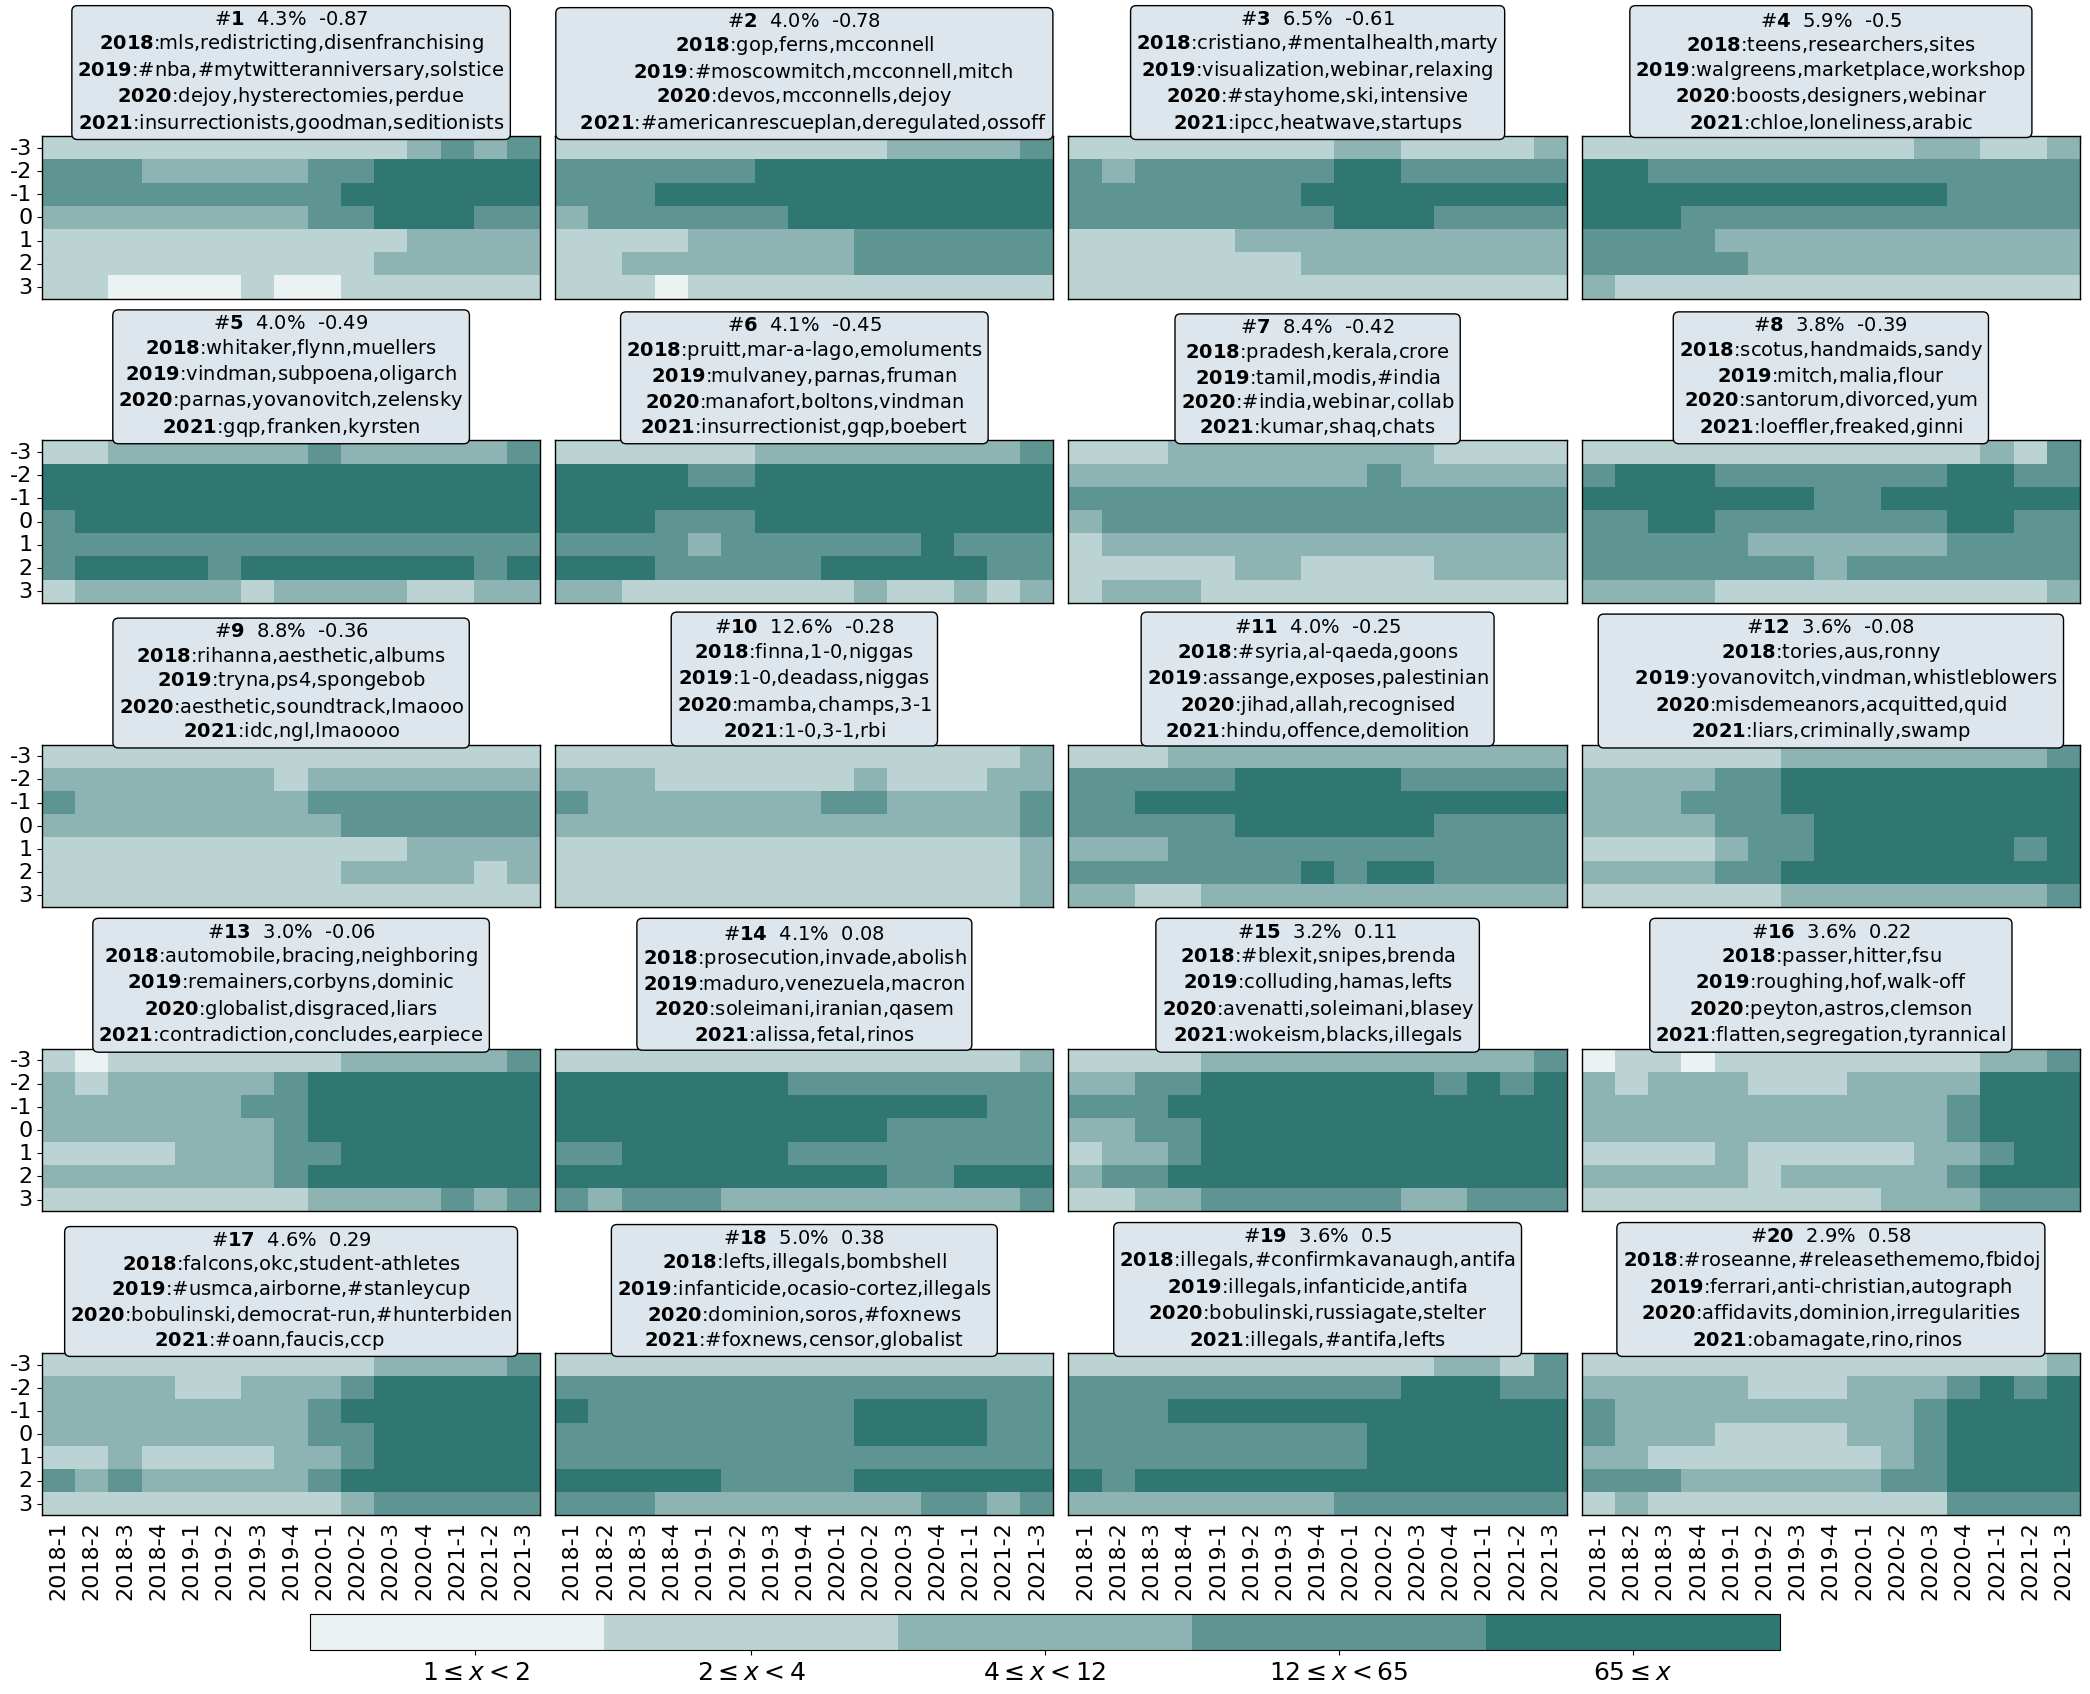

In [54]:
remapped_clusters = plot_clusters(rows=5,columns=4,
                                  engagement_counts_main=eng_counts_cluster_mean_true,
                                  figsize=(21,18),
                                  num_bins=5,color="#307672",
                                  save_path="cluster_plots/latest_cluster_plot_april2024.png",
                                  cluster_important_terms=cluster_imp_terms_binary,
                                  cluster_important_terms_date = cluster_imp_terms_by_time_binary,
                                  cluster_sizes=cluster_size_map_all)